plot figure with TSG, MUR, ship data and goes data of SST to reply to reviewer asking if the SST at 6m is representative of the surface sst.


In [11]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import glob
import matplotlib.ticker as ticker
import pandas as pd


def goes16_earth_coordinates(x,y):
    """
    author: Agostino Meroni
    goal: convert point (x,y) from the GOES16 fixed grid to the Earth coordinates (lat, lon) in degrees.
    input: 
    - x: x grid coordinate
    - y: y grid coordinate
    output:
    - lat: latitude [degrees]
    - lon: longitude [degrees]
    """
    req = 6378137 # m
    rpol = 6356752.31414 # m
    H = 42164160 # m
    lambda0 = -1.308996939 # rad

    a = np.sin(x)**2+np.cos(x)**2*(np.cos(y)**2+req**2*np.sin(y)**2/rpol**2) 
    b = -2*H*np.cos(x)*np.cos(y)
    c = H**2-req**2

    rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)

    sx = rs*np.cos(x)*np.cos(y)
    sy = -rs*np.sin(x)
    sz = rs*np.cos(x)*np.sin(y)

    lat = np.arctan(req**2*sz/(rpol**2*np.sqrt((H-sx)**2+sy**2)))
    lon = lambda0-np.arctan(sy/(H-sx))

    return lon*180/np.pi, lat*180/np.pi



def f_find_closest_data_point(lat, lon, dataset_var, string):
    '''
    input: 
    - lat: latitude array from the position to look for
    - lon: longitude array from the position to look for
    - dataset_var: xarray 2d variable dependent on lat/lon to search values closest
    - string: string identifying the type of dataset
    '''
    var_closest = np.zeros((len(lat)))
    var_closest.fill(np.nan)
                           
    # loop on the serie of values
    for ind_time in range(len(lat)):
        lat_sel = lat[ind_time]
        lon_sel = lon[ind_time]
        
        if np.isnan(lat_sel) or np.isnan(lon_sel):
            var_closest[ind_time] = np.nan
        else:
            var_sel_lat = dataset_var.sel(lat=lat[ind_time], method='nearest')
            var_sel_long = var_sel_lat.sel(lon=lon[ind_time], method='nearest')
            if string == 'mur':
                var_closest[ind_time] = var_sel_long.__xarray_dataarray_variable__.values
            else:
                #print(var_sel_long.analysed_sst.values)
                var_closest[ind_time] = var_sel_long.analysed_sst.values


    return(var_closest)
                           

In [5]:
# identifying time stamps of sst corresponding to time stamps of radiosondes
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)

In [ ]:
# define paths to the data and read the files - Claudia
tsg_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/tsg_sst_data/tsg/nc/msm_089_1_tsg.nc'
mur_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/satellite_data/submitted/2-3 Feb LT_SST_MUR_regridded.nc'
ship_file = '/Volumes/Extreme SSD/ship_motion_correction_merian/ship_data/new/ship_dataset_allvariables.nc'
GOES_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots_goes_quicklooks/SST_goes_merian.nc'

ship = xr.open_dataset(ship_file)
mur = xr.open_dataset(mur_file)

# reading ship data and extracting the time interval of interest
ship_slice = ship.sel(time=slice(t_start, t_end))
ship_slice

In [7]:
# define paths to the data - Agostino

tsg_file = '/home/agostino/SST-impact_data/msm_089_1_tsg.nc'
mur_file = '/home/agostino/SST-impact_data/2-3 Feb LT_SST_MUR_regridded.nc'
GOES_file = '/home/agostino/SST-impact_data/SST_goes_merian.nc'

In [6]:
# reading mur and tsg data and creating xarray dataset
mur = xr.open_dataset(mur_file)
tsg_data = xr.open_dataset(tsg_file)

# slicing tsg datase t for the selected time interval and extracting sst
sliced_tsg_ds = tsg_data.sel(TIME=slice(t_start, t_end))
tsg_sst = sliced_tsg_ds['TEMP'].values
tsg_time_sst = sliced_tsg_ds['TIME'].values
tsg_flag = sliced_tsg_ds['TEMP_QC'].values

# averaging together the sst of the different sst sensors for tsg
temp0 = sliced_tsg_ds.TEMP[:,0].values
temp1 = sliced_tsg_ds.TEMP[:,1].values
sst_tsg = temp0
sst_tsg[np.isnan(temp0)] = temp1[np.isnan(temp0)]

# producing output dataset of sst_tsg for the selected time window
# creating dataset with coordinates sst and height
dim_sst           = ['time']
coords         = {"time":sliced_tsg_ds.TIME.values}
SST              = xr.DataArray(dims=dim_sst, coords=coords, data=sst_tsg,
                 attrs={'long_name':'sea surface temperature ',
                        'units':'$^{\circ}$C'})
variables         = {'SST':SST}
sst_dataset      = xr.Dataset(data_vars = variables,
                       coords = coords)

In [8]:
# reading GOES dataset 
goes = xr.open_dataset(GOES_file)

In [9]:
goes

<xarray.Dataset>
Dimensions:  (time: 2880)
Coordinates:
  * time     (time) datetime64[ns] 2020-02-02T00:00:55.000003328 ... 2020-02-...
Data variables:
    SST      (time) float32 ...

In [14]:
# extract from lat lon of the mur map the closest to the ship position
sst_mur = f_find_closest_data_point(sliced_tsg_ds.LATITUDE.values,  sliced_tsg_ds.LONGITUDE.values, mur, 'mur')
len(sst_mur)

# Save the time series of the closest MUR SST values as a txt file named mur_closest_values_time_series.txt
time_tsg = sliced_tsg_ds.TIME.values
df_mur = pd.DataFrame({'time':time_tsg, 'sst_mur_closest': sst_mur})
df_mur.to_csv('mur_closest_values_time_series.txt',index=False)

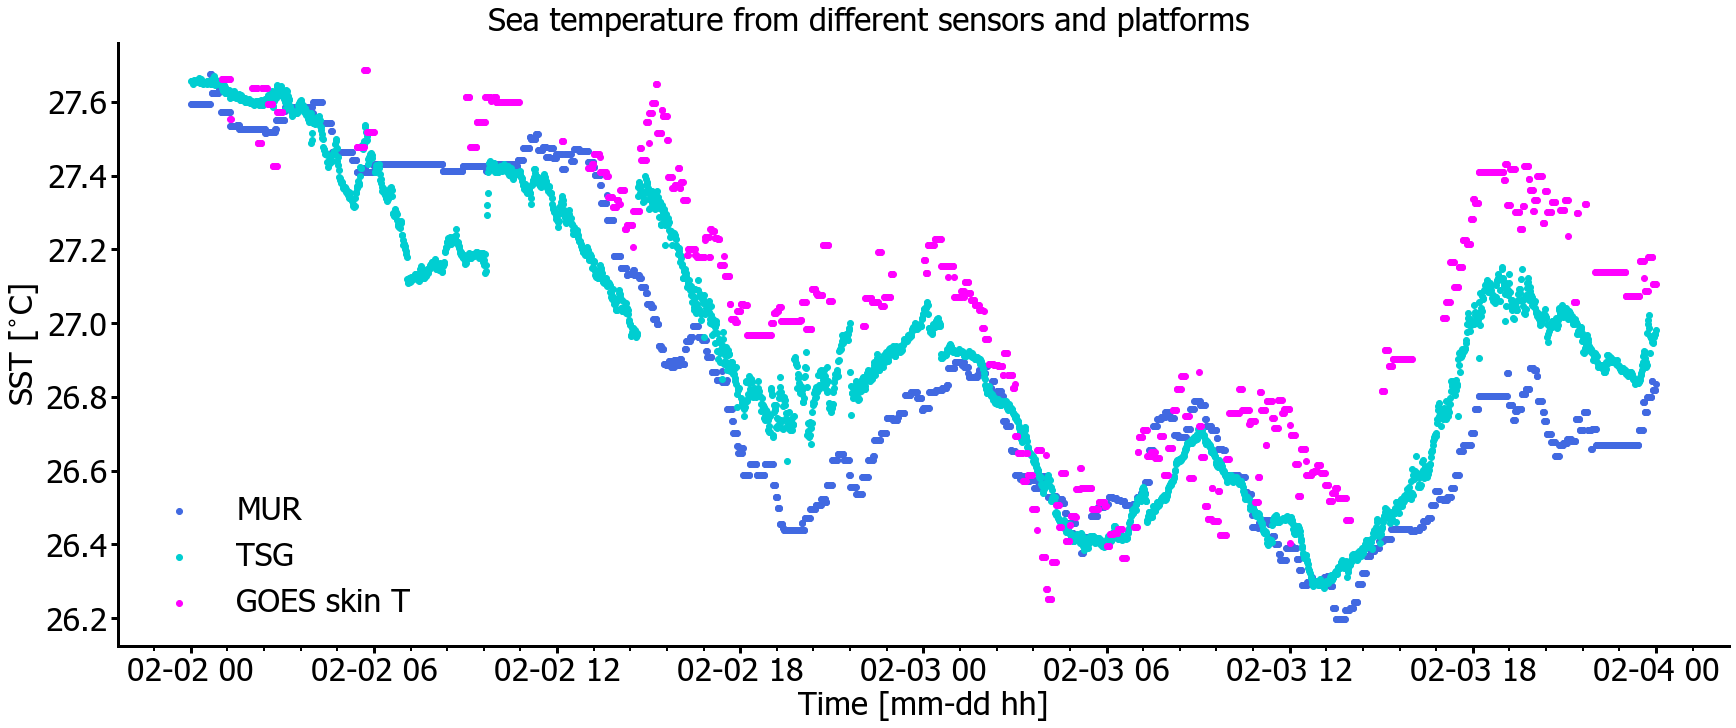

In [7]:
from matplotlib import rcParams
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots_paper/'

dict_plot_settings = {
    'labelsize'    :32,
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :32,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}

fig, axs = plt.subplots(1,1, figsize=(24,10), sharex=True, sharey=True, constrained_layout=True)
fig.suptitle("Sea temperature from different sensors and platforms", fontsize=32)
# colors=('r', 'green', 'blue', (1, 1, 0), '#afeeee', '0.5'),
# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})    
#ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)

axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)
axs.spines["bottom"].set_linewidth(3)
axs.spines["left"].set_linewidth(3)
axs.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axs.tick_params(which='minor', length=5, width=2)
axs.tick_params(which='major', length=7, width=3)
axs.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axs.tick_params(axis='both', labelsize=32)
axs.set_xlabel('Time [mm-dd hh]')
axs.set_ylabel('SST [$^{\circ}$C]', fontsize=fontSizeX)

plt.scatter(sliced_tsg_ds.TIME.values, sst_mur, label='MUR', color='royalblue', alpha=1)
plt.scatter(sliced_tsg_ds.TIME.values, sst_dataset.SST.values, label='TSG', color='darkturquoise', alpha=1,)
plt.scatter(goes.time.values, goes.SST.values-273.15, label='GOES skin T', color='fuchsia', alpha=1,)
#plt.scatter(ship_slice.time.values, ship_slice.SST.values, label='ship (3m depth)', s=2., alpha=1, color='palevioletred')
plt.legend(frameon=False)
fig.savefig(path_out_plots+'revierew_1_sst.png', format='png')

In [61]:
path_out_plots

'/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots_paper/'